<a href="https://colab.research.google.com/github/RenatoMaximiano/MPD_1_TrabalhoFinal/blob/main/V3_Balanceamento_Red_Wine_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Projeto final  Modelagem Preditiva e Descritiva I***

***Alunos:*** Bernardo Morales, Renato Maximiano.

***Banco de Dados:*** [Red-Wine-Quality](https://www.openml.org/search?type=data&status=active&qualities.NumberOfInstances=between_1000_10000&sort=runs&order=asc&id=43695)

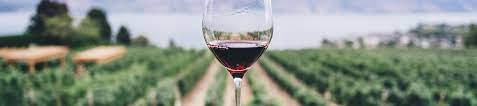

#***A atividade***

Selecionar um banco de dados do OpenML [openml](https://www.openml.org/)
     -- o banco de dados de classificação deve ter: > 3 classes, >10 atributos e >1000 instâncias
     -- cada dupla deve informar qual banco de dados usará com antecedência
-- 10-fold cross-validation
-- avaliar máquinas de aprendizagem: kNN, DT, MLP, NB, SVM, … 
-- métricas (area under the ROC curve, f1-score, accuracy, matriz de confusão média)
-- para ajustar os parâmetros das máquinas de aprendizagem usar grid-search ou escolher os parâmetros e justificar

O relatório final deve conter pelo menos as seguintes informações:
  1. Introdução
  2. Algoritmos de Aprendizagem de Máquina
  3. Experimentos
  3.1. Banco de dados
  3.2. Métricas
  3.3. Resultados 
  4. Conclusões
  Referências


#***Introdução***

Para este trabalho vamos utilizar o banco de dados Red-Wine-Quality, o conjunto de dados está relacionado com variantes tinto e branco do vinho português "Vinho Verde". Por questões de privacidade e logística, apenas variáveis físico-químicas (entradas) e sensoriais (saídas) estão disponíveis (por exemplo, não há dados sobre tipos de uva, marca de vinho, preço de venda do vinho etc.). Esses conjuntos de dados podem ser vistos como tarefas de classificação ou regressão. As classes são ordenadas e não equilibradas (por exemplo, há muito mais vinhos normais do que excelentes ou pobres).
Variáveis de entrada (com base em testes físico-químicos): 1 - acidez fixa 2 - acidez volátil 3 - ácido cítrico 4 - açúcar residual 5 - cloretos 6 - dióxido de enxofre livre 7 - dióxido de enxofre total 8 - densidade 9 - pH 10 - sulfatos 11 – álcool. Variável de saída (baseada em dados sensoriais): 12 - qualidade (pontuação entre 0 e 10).
Para facilitar as análises definimos 3 classes com base nas pontuações dos vinhos. De 0 até 5 (Ruim), igual a 6 (Regular), de 7 até 10 (Bom).  Para este trabalho utilizamos o Optuna como otimizador de hiper parâmetros. Também aplicamos um 10-fold cross-validation dentro de cada iteração, utilizando a melhor média de acurácia para escolher os melhores hiper parâmetros.


#***Fluxograma***
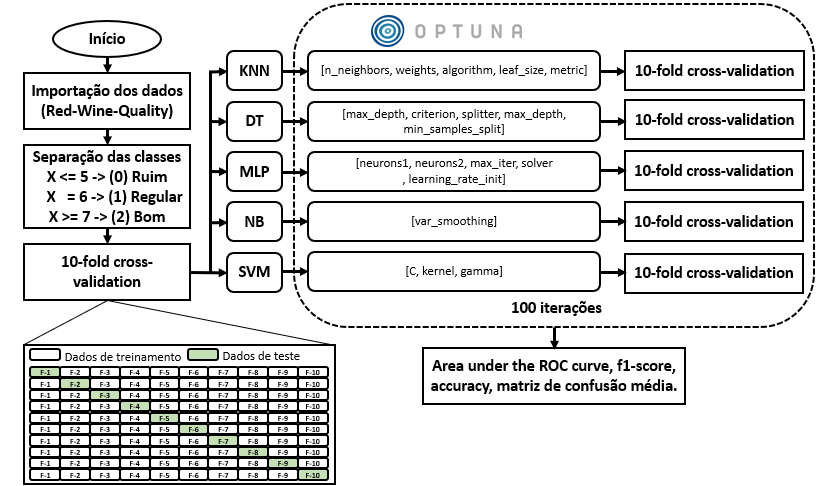

#***Bibliotecas utilizadas no projeto***

In [3]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.2 MB/s 
     |████████████████████████████████| 81 kB 6.4 MB/s 
     |████████████████████████████████| 209 kB 28.5 MB/s 
     |████████████████████████████████| 78 kB 6.0 MB/s 
     |████████████████████████████████| 147 kB 70.1 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 112 kB 37.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=9a598baa6e66ee0c6fa9202f146b6f68ee458a6df19886db6034fd0ce7c18a7d
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [4]:
#Bibliotecas de manipualção e visualização de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
from scipy.io.arff import loadarff 

#Classes do modelo de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from sklearn.svm import SVC

#Funções de avaliação dos modelos
from sklearn.metrics import classification_report, mean_squared_error, r2_score, accuracy_score, f1_score, plot_roc_curve, recall_score
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical
from sklearn.pipeline import Pipeline
import warnings
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import optuna
from optuna.samplers import TPESampler
import random as python_random
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')


In [5]:
def reset_seeds():
   np.random.seed(4) 
   python_random.seed(9498)
   tf.random.set_seed(9)

reset_seeds() 

#***Banco de Dados***

Aqui é feito a importação dos dados, a separação das classes e as analises iniciais. 

In [55]:
#Importação dos dados
raw_data = loadarff('/content/drive/MyDrive/Trabalho_APD/Red_wine')
df_data = pd.DataFrame(raw_data[0])

#Separação das classes.
df_data.loc[df_data["quality"] == 3, "quality"] = 0
df_data.loc[df_data["quality"] == 4, "quality"] = 0
df_data.loc[df_data["quality"] == 5, "quality"] = 0
df_data.loc[df_data["quality"] == 6, "quality"] = 1
df_data.loc[df_data["quality"] == 7, "quality"] = 2
df_data.loc[df_data["quality"] == 8, "quality"] = 2

#Analises iniciais
#df_data = df_data.apply(lambda x: x.str.decode('utf8'))
print("Quantas classes existem nesse dataset?\n%d" %(len(df_data["quality"].unique())))
print("\nQuantas instâncias existem no dataset?\n%d" %(len(df_data)))
print("\nQuantas features existem no dataset?\n%d" %(df_data.shape[1]))
print("\nQue features são essas?\n%s" %(str([k for k in df_data.keys()])))
print("\nQual o numero de instâncias por classe?")
print(df_data["quality"].value_counts())
dataset=df_data
df_data.head()

Quantas classes existem nesse dataset?
3

Quantas instâncias existem no dataset?
1599

Quantas features existem no dataset?
12

Que features são essas?
['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Qual o numero de instâncias por classe?
0.0    744
1.0    638
2.0    217
Name: quality, dtype: int64


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0


In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#***Normalização dos dados (Min/Max)***

In [57]:
df_norm = df_data[['fixed_acidity',	'volatile_acidity',	'citric_acid',	'residual_sugar', 'chlorides',	'free_sulfur_dioxide',	
                   'total_sulfur_dioxide',	'density',	'pH',	'sulphates',	'alcohol']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df_norm.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846
1,0.283186,0.520548,0.00,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385
2,0.283186,0.438356,0.04,0.095890,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385
3,0.584071,0.109589,0.56,0.068493,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385
4,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846


In [58]:
target = df_data[['quality']]

In [59]:
df_data = pd.concat([df_norm, target], axis=1)
df_data.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,0.0
1,0.283186,0.520548,0.00,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385,0.0
2,0.283186,0.438356,0.04,0.095890,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385,0.0
3,0.584071,0.109589,0.56,0.068493,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385,1.0
4,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,0.0


#***Visualização de espaço de parâmetros***

Confrontando feature por feature.

In [48]:
sns.pairplot(data=df_data, vars=('fixed_acidity',	'volatile_acidity',	'citric_acid',	'residual_sugar',
                               'chlorides',	'free_sulfur_dioxide',	'total_sulfur_dioxide',	'density',	'pH',	'sulphates',	'alcohol'), hue='quality', palette=sns.color_palette()[:3])

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f2f03b9b830> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f2f03ba3320> (for post_execute):


KeyboardInterrupt: ignored

#***Separando o Dataset em 10-Fold*** 

Obtendo os índices de forma misturada e aleatória, para o conjunto de treinamento e teste. Onde sempre teremos 9 para treinamento  vs 1 para teste. 

In [60]:
#Aqui os índices são obtidos, guardados em suas respectivas listas de treinamento e teste, para serem utilizados posteriormente.
dataset=df_data
Train_index = []
Test_index = []
kf = KFold(n_splits=10, random_state=9, shuffle=True)
for train_index, test_index in kf.split(dataset):
   Train_index.append(train_index)
   Test_index.append(test_index)

In [61]:
#Dividindo os dados de entrada dos dados alvos de interesse. 
X = dataset.iloc[:,[0,1,2,3,4,5,6,7,8,9,10]]
y = dataset.iloc[:,[11]]
def Train_test_Kfold(n):
  #Separando o conjunto de dados em treinamento e teste
  global Xtrain, ytrain, Xtest, ytest
  Xtrain, ytrain, Xtest, ytest = X.iloc[Train_index[n]], y.iloc[Train_index[n]], X.iloc[Test_index[n]], y.iloc[Test_index[n]]

#***KNN (K-Nearest Neighbors)***

**********************0**********************
[2, 'distance', 'ball_tree', 45, 'manhattan'] -> accuracy:0.7125 -> F1-Macro:0.6732044063647491recall score-macro:0.6990933756865859
**********************1**********************
[2, 'uniform', 'auto', 21, 'manhattan'] -> accuracy:0.66875 -> F1-Macro:0.6002090177665101recall score-macro:0.5883099672176885
**********************2**********************
[1, 'distance', 'ball_tree', 40, 'euclidean'] -> accuracy:0.63125 -> F1-Macro:0.6031154713840833recall score-macro:0.6152777777777777
**********************3**********************
[1, 'distance', 'ball_tree', 40, 'euclidean'] -> accuracy:0.66875 -> F1-Macro:0.6415157967965249recall score-macro:0.6587830066090935
**********************4**********************
[1, 'distance', 'kd_tree', 30, 'euclidean'] -> accuracy:0.6625 -> F1-Macro:0.6215801491536785recall score-macro:0.619042678287335
**********************5**********************
[1, 'distance', 'ball_tree', 40, 'euclidean'] -> accuracy:0.65 ->

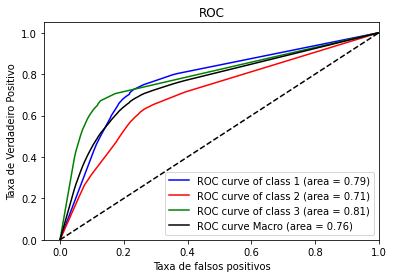

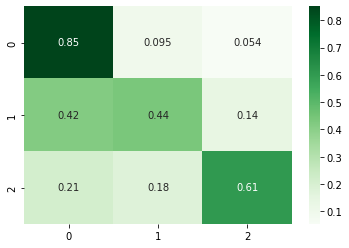

**********************0**********************
[12, 'distance', 'ball_tree', 20, 'euclidean'] -> accuracy:0.60625 -> F1-Macro:0.5642952654427871recall score-macro:0.6311847881234421
**********************1**********************
[10, 'distance', 'auto', 30, 'minkowski'] -> accuracy:0.575 -> F1-Macro:0.5314285714285715recall score-macro:0.5709248796819418
**********************2**********************
[15, 'distance', 'ball_tree', 49, 'minkowski'] -> accuracy:0.5875 -> F1-Macro:0.5371431533963613recall score-macro:0.5819444444444444
**********************3**********************
[12, 'distance', 'kd_tree', 47, 'minkowski'] -> accuracy:0.6375 -> F1-Macro:0.5947772657450077recall score-macro:0.6202164897817072
**********************4**********************
[14, 'distance', 'brute', 23, 'euclidean'] -> accuracy:0.65625 -> F1-Macro:0.6172624073552865recall score-macro:0.6720758110258007
**********************5**********************
[12, 'distance', 'ball_tree', 20, 'euclidean'] -> accuracy:0.475

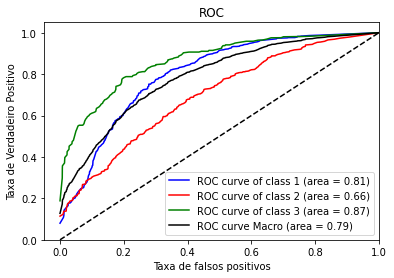

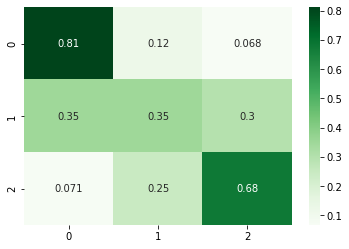

**********************0**********************
[15, 'distance', 'ball_tree', 42, 'manhattan'] -> accuracy:0.69375 -> F1-Macro:0.6621301837602779recall score-macro:0.7264575474819668
**********************1**********************
[1, 'distance', 'ball_tree', 40, 'euclidean'] -> accuracy:0.68125 -> F1-Macro:0.6542132799020427recall score-macro:0.6795215177512729
**********************2**********************
[3, 'distance', 'brute', 46, 'manhattan'] -> accuracy:0.6625 -> F1-Macro:0.6324313079101922recall score-macro:0.6611111111111111
**********************3**********************
[2, 'distance', 'auto', 20, 'euclidean'] -> accuracy:0.6375 -> F1-Macro:0.6107334307992203recall score-macro:0.6354739833000703
**********************4**********************
[3, 'distance', 'brute', 20, 'manhattan'] -> accuracy:0.65625 -> F1-Macro:0.6179654605651833recall score-macro:0.6260254547969841
**********************5**********************
[18, 'distance', 'ball_tree', 26, 'euclidean'] -> accuracy:0.59375 -

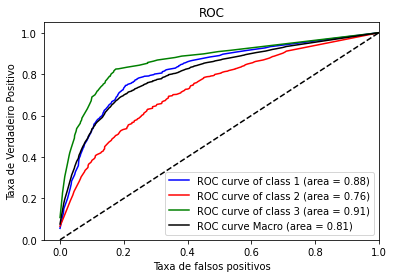

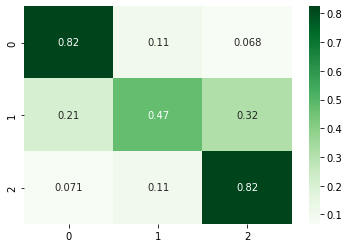

In [63]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import NearMiss
Sampler_list = [SMOTE(random_state = 9),NearMiss(),"SMOTE_Near"]

for Sampler in Sampler_list:
  #Definições de listas para gurdar os valores obtidos em cada iteração 
  #Lista para as pontuações atingidas para cada iteração
  Score_list = []
  #Lista para as pontuações f1-Maxro atingidas para cada iteração
  F1_macro   = []
  #Lista para as pontuações recall_score atingidas para cada iteração
  recall_score_macro = []
  #Lista para as matrizes de confusão atingidas em cada iteração
  cm_list    = []
  #FRP, TPR, ROC_AUC da classe 1
  FRP_0      = []
  TPR_0      = []
  ROC_auc_0  = []
  #FRP, TPR, ROC_AUC da classe 2
  FRP_1      = []
  TPR_1      = []
  ROC_auc_1  = []
  #FRP, TPR, ROC_AUC da classe 3
  FRP_2      = []
  TPR_2      = []
  ROC_auc_2  = []

  #Importancia dos hiperparametros
  h_0 = []
  h_1 = []
  h_2 = []
  h_3 = []
  h_4 = []
  #Iniciando iterações
  for i in range(10):
          #Chamada de cada fold 
          Train_test_Kfold(i)
          Best = 0.0
          reset_seeds()
          def objective(trial):         
            #Busca de hiperparametros utilizando o Optruna como otimizador
            n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
            weights     = trial.suggest_categorical("weights", ['uniform', 'distance'])
            algorithm   = trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"])
            leaf_size   = trial.suggest_int("leaf_size", 20, 50)
            metric      = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])

            #Modelo Utilizado -> KNN
            model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size, metric=metric)

            #Variaveis globais
            global Best
            global Model
            global Lista
            if Sampler == "SMOTE_Near":
              oversample = SMOTE(random_state = 9,sampling_strategy={2:480})
              X_res, y_res = oversample.fit_resample(Xtrain, ytrain)
              undersample=NearMiss(sampling_strategy={0:480, 1:480})
              X_res, y_res = undersample.fit_resample( X_res, y_res) 
            else:
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            #steps = [('over', SMOTE(random_state = 9)), ('model', model)]
            #pipeline = Pipeline(steps=steps)
            #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
            kfold = StratifiedKFold(n_splits=10)
            score = cross_val_score(model,X_res, y_res, scoring='accuracy', cv=kfold)
            #Pontuação media Obtida
            Score = score.mean()

            #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
            if Score > Best:
              Best = Score
              model.fit(X_res, y_res)
              Model = model
              Lista = [n_neighbors,weights,algorithm,leaf_size,metric]


            return Score

          #Chamada do Optuna 
          sampler = TPESampler(seed=42) 
          study = optuna.create_study(direction="maximize", sampler=sampler)
          #Definição do numero de iterações -> 100
          study.optimize(objective, n_trials=100)

          Importance = optuna.importance.get_param_importances(study)

          h_0.append(Importance["n_neighbors"])
          h_1.append(Importance["weights"])
          h_2.append(Importance["algorithm"])
          h_3.append(Importance["leaf_size"])
          h_4.append(Importance["metric"])
          

          #Ativação do modelo  para os dados de teste (1/10)
          ypred = Model.predict(Xtest)
          #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
          Acc = accuracy_score(ytest, ypred)
          F1 = f1_score(ytest, ypred, average='macro')
          rs = recall_score(ytest, ypred, average='macro')
          cm = confusion_matrix(ytest, ypred, normalize="true")
          #Append dos resultados obtidos na iteração
          Score_list.append(Acc)
          F1_macro.append(F1)
          recall_score_macro.append(rs)
          cm_list.append(cm)

          #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
          y_score = Model.predict_proba(Xtest)
          y_test = label_binarize(ytest, classes=[0,1,2])
          fpr = dict()
          tpr = dict()
          roc_auc = dict()
          for j in range(3):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
          FRP_0.append(fpr[0])
          TPR_0.append(tpr[0])
          ROC_auc_0.append(roc_auc[0])
          FRP_1.append(fpr[1])
          TPR_1.append(tpr[1])
          ROC_auc_1.append(roc_auc[1])
          FRP_2.append(fpr[2])
          TPR_2.append(tpr[2])
          ROC_auc_2.append(roc_auc[2])

          print("**********************"+str(i)+"**********************")
          print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

  #Criação da matriz de confusão media
  cm_sum = cm_list[0]
  for i in range(9):
    cm_sum = cm_list[i+1]+cm_sum
  cm_mean= cm_sum/10

  #Criação da curva ROC media
  all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

  mean_tpr_0 = np.zeros_like(all_fpr_0)
  for i in range(10):
      mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
  mean_tpr_0 /= 10

  all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

  mean_tpr_1 = np.zeros_like(all_fpr_1)
  for i in range(10):
      mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
  mean_tpr_1 /= 10


  all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

  mean_tpr_2 = np.zeros_like(all_fpr_2)
  for i in range(10):
      mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
  mean_tpr_2 /= 10

  FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
  TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

  all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
      mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
  mean_tpr /= 3

  #Pontuações e desvio padrão
  print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
  print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
  print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))
  print("n_neighbors: %.2f%%, weights: %.2f%%, algorithm: %.2f%%, leaf_size: %.2f%%, metric: %.2f%%" % (np.array(h_0).mean(), np.array(h_1).mean(), np.array(h_2).mean(),np.array(h_3).mean(),np.array(h_4).mean()))
  #Plots Finais
  roc_auc[3] = (auc(all_fpr, mean_tpr))
  colors = cycle(['blue', 'red', 'green'])
  a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
  b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
  for i, color in zip(range(3), colors):
      plt.plot(a[i], b[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i+1, roc_auc[i]))

  plt.plot(a[3], b[3], color="black",
              label='ROC curve Macro (area = {1:0.2f})'
              ''.format(1, roc_auc[3]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de falsos positivos')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()
  sns.heatmap(cm, annot=True, cmap="Greens")
  plt.show()

#***DT (Decision tree)***

**********************0**********************
[15, 'entropy', 'best', 3, 1] -> accuracy:0.66875 -> F1-Macro:0.6653572276975311recall score-macro:0.6942403988264619
**********************1**********************
[18, 'entropy', 'best', 5, 1] -> accuracy:0.68125 -> F1-Macro:0.671094566353187recall score-macro:0.6874694845504639
**********************2**********************
[17, 'gini', 'random', 4, 1] -> accuracy:0.6875 -> F1-Macro:0.6396684814559211recall score-macro:0.6555555555555556
**********************4**********************
[18, 'gini', 'random', 3, 1] -> accuracy:0.6625 -> F1-Macro:0.6050627725969301recall score-macro:0.6153074635124853
**********************5**********************
[14, 'entropy', 'best', 3, 3] -> accuracy:0.58125 -> F1-Macro:0.559452766613892recall score-macro:0.5767877782803156
**********************6**********************
[18, 'entropy', 'best', 5, 1] -> accuracy:0.66875 -> F1-Macro:0.6219670039194239recall score-macro:0.6546070460704607
**********************

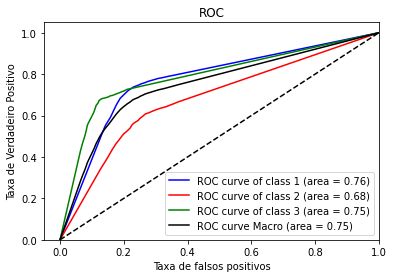

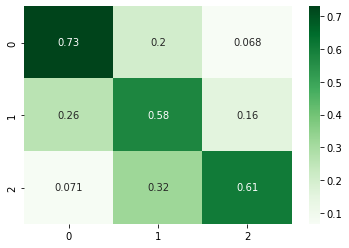

**********************0**********************
[10, 'gini', 'random', 3, 3] -> accuracy:0.51875 -> F1-Macro:0.4804059753766645recall score-macro:0.5519819998676461
**********************1**********************
[10, 'gini', 'best', 3, 1] -> accuracy:0.63125 -> F1-Macro:0.5906177499901695recall score-macro:0.6251168305782241
**********************2**********************
[20, 'entropy', 'random', 4, 1] -> accuracy:0.5375 -> F1-Macro:0.4920557269846048recall score-macro:0.5097222222222223
**********************3**********************
[15, 'entropy', 'random', 2, 2] -> accuracy:0.46875 -> F1-Macro:0.4298773971671168recall score-macro:0.47311286441721223
**********************4**********************
[12, 'entropy', 'random', 2, 3] -> accuracy:0.50625 -> F1-Macro:0.4811549183592194recall score-macro:0.5396901155149755
**********************5**********************
[15, 'gini', 'best', 4, 3] -> accuracy:0.5 -> F1-Macro:0.4849203270255902recall score-macro:0.5191048126371509
*********************

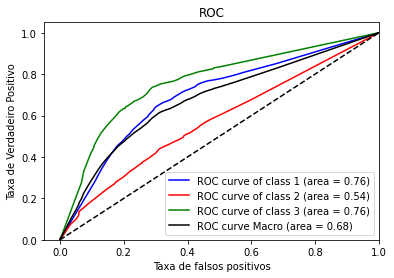

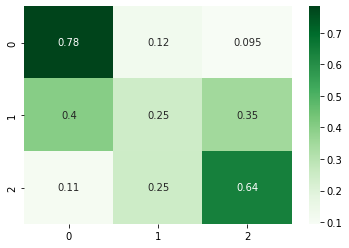

**********************0**********************
[15, 'gini', 'best', 5, 1] -> accuracy:0.6875 -> F1-Macro:0.650554719575417recall score-macro:0.6674056426885492
**********************1**********************
[20, 'gini', 'random', 2, 1] -> accuracy:0.575 -> F1-Macro:0.5536034619201707recall score-macro:0.5893387738020506
**********************2**********************
[18, 'entropy', 'random', 2, 1] -> accuracy:0.64375 -> F1-Macro:0.5682297531267784recall score-macro:0.5750000000000001
**********************3**********************
[20, 'entropy', 'random', 3, 1] -> accuracy:0.5625 -> F1-Macro:0.5472208256521981recall score-macro:0.5674991761948284
**********************4**********************
[19, 'gini', 'best', 5, 1] -> accuracy:0.60625 -> F1-Macro:0.5604672545849017recall score-macro:0.554928408383482
**********************5**********************
[17, 'gini', 'best', 4, 3] -> accuracy:0.6125 -> F1-Macro:0.5823110654333675recall score-macro:0.586997671574786
**********************6*******

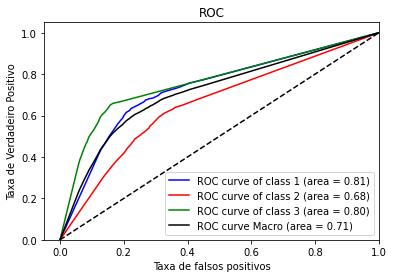

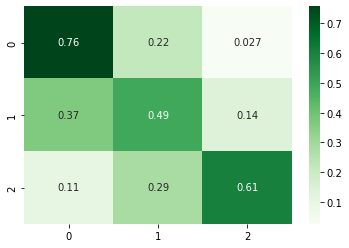

In [ ]:
for Sampler in Sampler_list:
  #Definições de listas para guardar os valores obtidos em cada iteração 
  #Lista para as pontuações atingidas para cada iteração
  Score_list = []
  #Lista para as pontuações f1-Maxro atingidas para cada iteração
  F1_macro   = []
  #Lista para as pontuações recall_score atingidas para cada iteração
  recall_score_macro = []
  #Lista para as matrizes de confusão atingidas em cada iteração
  cm_list    = []
  #FRP, TPR, ROC_AUC da classe 1
  FRP_0      = []
  TPR_0      = []
  ROC_auc_0  = []
  #FRP, TPR, ROC_AUC da classe 2
  FRP_1      = []
  TPR_1      = []
  ROC_auc_1  = []
  #FRP, TPR, ROC_AUC da classe 3
  FRP_2      = []
  TPR_2      = []
  ROC_auc_2  = []

  #Importancia dos hiperparametros
  h_0 = []
  h_1 = []
  h_2 = []
  h_3 = []
  h_4 = []

  #Iniciando iterações
  for i in range(10):
          #Chamada de cada fold 
          Train_test_Kfold(i)
          Best = 0.0
          reset_seeds()
          def objective(trial):         
            #Busca de hiperparametros utilizando o Optruna como otimizador
            max_depth = trial.suggest_int("max_depth", 10,20)
            criterion     = trial.suggest_categorical("criterion", ['gini', 'entropy'])
            splitter   = trial.suggest_categorical("splitter", ["best", "random"])
            min_samples_split   = trial.suggest_int("min_samples_split", 2,5)
            min_samples_leaf   = trial.suggest_int("min_samples_leaf", 1, 3)

            #Modelo Utilizado -> KNN
            model = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

            #Variaveis globais
            global Best
            global Model
            global Lista
            if Sampler == "SMOTE_Near":
              oversample = SMOTE(random_state = 9,sampling_strategy={2:480})
              X_res, y_res = oversample.fit_resample(Xtrain, ytrain)
              undersample=NearMiss(sampling_strategy={0:480, 1:480})
              X_res, y_res = undersample.fit_resample( X_res, y_res) 
            else:
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            #steps = [('over', SMOTE(random_state = 9)), ('model', model)]
            #pipeline = Pipeline(steps=steps)
            #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
            kfold = StratifiedKFold(n_splits=10)
            score = cross_val_score(model,X_res, y_res, scoring='accuracy', cv=kfold)
            #Pontuação media Obtida
            Score = score.mean()

            #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
            if Score > Best:
              Best = Score
              model.fit(X_res, y_res)
              Model = model
              Lista = [max_depth,criterion,splitter,min_samples_split,min_samples_leaf]


            return Score

          #Chamada do Optuna 
          sampler = TPESampler(seed=42) 
          study = optuna.create_study(direction="maximize", sampler=sampler)
          #Definição do numero de iterações -> 100
          study.optimize(objective, n_trials=100)

          Importance = optuna.importance.get_param_importances(study)

          h_0.append(Importance["max_depth"])
          h_1.append(Importance["criterion"])
          h_2.append(Importance["splitter"])
          h_3.append(Importance["min_samples_split"])
          h_4.append(Importance["min_samples_leaf"])
          

          #Ativação do modelo  para os dados de teste (1/10)
          ypred = Model.predict(Xtest)
          #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
          Acc = accuracy_score(ytest, ypred)
          F1 = f1_score(ytest, ypred, average='macro')
          rs = recall_score(ytest, ypred, average='macro')
          cm = confusion_matrix(ytest, ypred, normalize="true")
          #Append dos resultados obtidos na iteração
          Score_list.append(Acc)
          F1_macro.append(F1)
          recall_score_macro.append(rs)
          cm_list.append(cm)

          #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
          y_score = Model.predict_proba(Xtest)
          y_test = label_binarize(ytest, classes=[0,1,2])
          fpr = dict()
          tpr = dict()
          roc_auc = dict()
          for j in range(3):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
          FRP_0.append(fpr[0])
          TPR_0.append(tpr[0])
          ROC_auc_0.append(roc_auc[0])
          FRP_1.append(fpr[1])
          TPR_1.append(tpr[1])
          ROC_auc_1.append(roc_auc[1])
          FRP_2.append(fpr[2])
          TPR_2.append(tpr[2])
          ROC_auc_2.append(roc_auc[2])

          print("**********************"+str(i)+"**********************")
          print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

  #Criação da matriz de confusão media
  cm_sum = cm_list[0]
  for i in range(9):
    cm_sum = cm_list[i+1]+cm_sum
  cm_mean= cm_sum/10

  #Criação da curva ROC media
  all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

  mean_tpr_0 = np.zeros_like(all_fpr_0)
  for i in range(10):
      mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
  mean_tpr_0 /= 10

  all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

  mean_tpr_1 = np.zeros_like(all_fpr_1)
  for i in range(10):
      mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
  mean_tpr_1 /= 10


  all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

  mean_tpr_2 = np.zeros_like(all_fpr_2)
  for i in range(10):
      mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
  mean_tpr_2 /= 10

  FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
  TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

  all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
      mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
  mean_tpr /= 3

  #Pontuações e desvio padrão
  print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
  print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
  print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))
  print("max_depth: %.2f%%, criterion: %.2f%%, splitter: %.2f%%, min_samples_split: %.2f%%, min_samples_leaf: %.2f%%" % (np.array(h_0).mean(), np.array(h_1).mean(), np.array(h_2).mean(),np.array(h_3).mean(),np.array(h_4).mean()))
  #Plots Finais
  roc_auc[3] = (auc(all_fpr, mean_tpr))
  colors = cycle(['blue', 'red', 'green'])
  a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
  b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
  for i, color in zip(range(3), colors):
      plt.plot(a[i], b[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i+1, roc_auc[i]))

  plt.plot(a[3], b[3], color="black",
              label='ROC curve Macro (area = {1:0.2f})'
              ''.format(1, roc_auc[3]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de falsos positivos')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()
  sns.heatmap(cm, annot=True, cmap="Greens")
  plt.show()

#***GNB (Gaussian Naive Bayes)***

**********************0**********************
[3.807947176588889e-09] -> accuracy:0.51875 -> F1-Macro:0.5030965391621128recall score-macro:0.5814748637857631
**********************1**********************
[3.807947176588889e-09] -> accuracy:0.50625 -> F1-Macro:0.4894310364118952recall score-macro:0.5522947618051196
**********************2**********************
[3.807947176588889e-09] -> accuracy:0.59375 -> F1-Macro:0.5632893240369876recall score-macro:0.6291666666666667
**********************3**********************
[3.807947176588889e-09] -> accuracy:0.46875 -> F1-Macro:0.4521443208430913recall score-macro:0.48758385714907454
**********************4**********************
[3.807947176588889e-09] -> accuracy:0.65625 -> F1-Macro:0.6253171084863092recall score-macro:0.6832814553503495
**********************5**********************
[3.807947176588889e-09] -> accuracy:0.49375 -> F1-Macro:0.48938242508087293recall score-macro:0.5358644487997721
**********************6**********************
[3.8

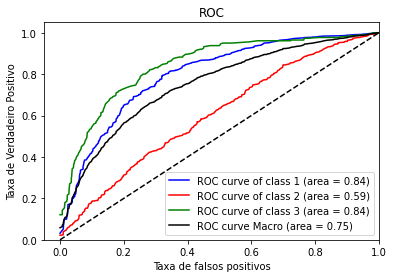

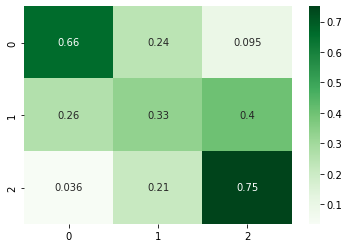

**********************0**********************
[3.807947176588889e-09] -> accuracy:0.4625 -> F1-Macro:0.43302560812915164recall score-macro:0.4835109081684424
**********************1**********************
[3.807947176588889e-09] -> accuracy:0.4125 -> F1-Macro:0.355326245570148recall score-macro:0.42194671130641
**********************2**********************
[3.807947176588889e-09] -> accuracy:0.45625 -> F1-Macro:0.41019172144999966recall score-macro:0.4513888888888889
**********************3**********************
[3.807947176588889e-09] -> accuracy:0.36875 -> F1-Macro:0.35176651305683565recall score-macro:0.37925503142894446
**********************4**********************
[3.807947176588889e-09] -> accuracy:0.44375 -> F1-Macro:0.4105970067430514recall score-macro:0.5024728505222383
**********************5**********************
[3.807947176588889e-09] -> accuracy:0.39375 -> F1-Macro:0.3819866408101702recall score-macro:0.3967703569693619
**********************6**********************
[3.8079

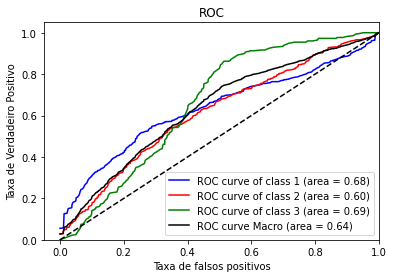

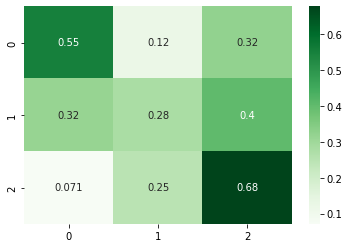

**********************0**********************
[3.807947176588889e-09] -> accuracy:0.55625 -> F1-Macro:0.5350829337391487recall score-macro:0.6230891403613262
**********************1**********************
[3.807947176588889e-09] -> accuracy:0.5875 -> F1-Macro:0.542461644429138recall score-macro:0.5917067726860571
**********************2**********************
[3.807947176588889e-09] -> accuracy:0.5625 -> F1-Macro:0.5176619433198381recall score-macro:0.5875
**********************3**********************
[3.807947176588889e-09] -> accuracy:0.53125 -> F1-Macro:0.5128363971647554recall score-macro:0.5765144026013591
**********************4**********************
[3.807947176588889e-09] -> accuracy:0.625 -> F1-Macro:0.5846053970593396recall score-macro:0.6397765788199489
**********************5**********************
[3.807947176588889e-09] -> accuracy:0.50625 -> F1-Macro:0.4885172798216277recall score-macro:0.5166340017086286
**********************6**********************
[3.807947176588889e-09]

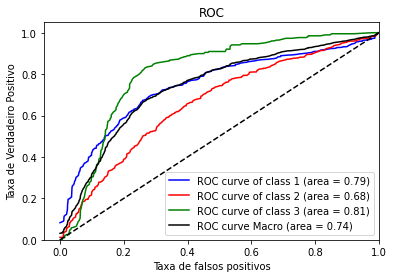

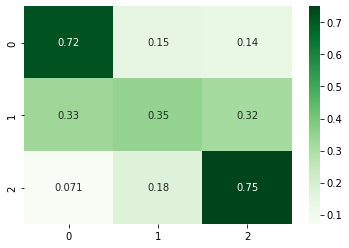

In [ ]:
for Sampler in Sampler_list:
  #Definições de listas para gurdar os valores obtidos em cada iteração 
  #Lista para as pontuações atingidas para cada iteração
  Score_list = []
  #Lista para as pontuações f1-Maxro atingidas para cada iteração
  F1_macro   = []
  #Lista para as pontuações recall_score atingidas para cada iteração
  recall_score_macro = []
  #Lista para as matrizes de confusão atingidas em cada iteração
  cm_list    = []
  #FRP, TPR, ROC_AUC da classe 1
  FRP_0      = []
  TPR_0      = []
  ROC_auc_0  = []
  #FRP, TPR, ROC_AUC da classe 2
  FRP_1      = []
  TPR_1      = []
  ROC_auc_1  = []
  #FRP, TPR, ROC_AUC da classe 3
  FRP_2      = []
  TPR_2      = []
  ROC_auc_2  = []

  #Importancia dos hiperparametros
  h_0 = []
  #Iniciando iterações
  for i in range(10):
          #Chamada de cada fold 
          Train_test_Kfold(i)
          Best = 0.0
          reset_seeds()
          def objective(trial):         
            #Busca de hiperparametros utilizando o Optruna como otimizador
            var_smoothing = trial.suggest_float("var_smoothing", 1e-10, 1e-08)

            #Modelo Utilizado -> KNN
            model = GaussianNB(var_smoothing=var_smoothing)

            #Variaveis globais
            global Best
            global Model
            global Lista
            if Sampler == "SMOTE_Near":
              oversample = SMOTE(random_state = 9,sampling_strategy={2:480})
              X_res, y_res = oversample.fit_resample(Xtrain, ytrain)
              undersample=NearMiss(sampling_strategy={0:480, 1:480})
              X_res, y_res = undersample.fit_resample( X_res, y_res) 
            else:
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            #steps = [('over', SMOTE(random_state = 9)), ('model', model)]
            #pipeline = Pipeline(steps=steps)
            #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
            kfold = StratifiedKFold(n_splits=10)
            score = cross_val_score(model,X_res, y_res, scoring='accuracy', cv=kfold)
            #Pontuação media Obtida
            Score = score.mean()

            #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
            if Score > Best:
              Best = Score
              model.fit(X_res, y_res)
              Model = model
              Lista = [var_smoothing]


            return Score

          #Chamada do Optuna 
          sampler = TPESampler(seed=42) 
          study = optuna.create_study(direction="maximize", sampler=sampler)
          #Definição do numero de iterações -> 100
          study.optimize(objective, n_trials=100)

          #Ativação do modelo  para os dados de teste (1/10)
          ypred = Model.predict(Xtest)
          #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
          Acc = accuracy_score(ytest, ypred)
          F1 = f1_score(ytest, ypred, average='macro')
          rs = recall_score(ytest, ypred, average='macro')
          cm = confusion_matrix(ytest, ypred, normalize="true")
          #Append dos resultados obtidos na iteração
          Score_list.append(Acc)
          F1_macro.append(F1)
          recall_score_macro.append(rs)
          cm_list.append(cm)

          #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
          y_score = Model.predict_proba(Xtest)
          y_test = label_binarize(ytest, classes=[0,1,2])
          fpr = dict()
          tpr = dict()
          roc_auc = dict()
          for j in range(3):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
          FRP_0.append(fpr[0])
          TPR_0.append(tpr[0])
          ROC_auc_0.append(roc_auc[0])
          FRP_1.append(fpr[1])
          TPR_1.append(tpr[1])
          ROC_auc_1.append(roc_auc[1])
          FRP_2.append(fpr[2])
          TPR_2.append(tpr[2])
          ROC_auc_2.append(roc_auc[2])

          print("**********************"+str(i)+"**********************")
          print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

  #Criação da matriz de confusão media
  cm_sum = cm_list[0]
  for i in range(9):
    cm_sum = cm_list[i+1]+cm_sum
  cm_mean= cm_sum/10

  #Criação da curva ROC media
  all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

  mean_tpr_0 = np.zeros_like(all_fpr_0)
  for i in range(10):
      mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
  mean_tpr_0 /= 10

  all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

  mean_tpr_1 = np.zeros_like(all_fpr_1)
  for i in range(10):
      mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
  mean_tpr_1 /= 10


  all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

  mean_tpr_2 = np.zeros_like(all_fpr_2)
  for i in range(10):
      mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
  mean_tpr_2 /= 10

  FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
  TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

  all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
      mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
  mean_tpr /= 3

  #Pontuações e desvio padrão
  print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
  print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
  print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))

  #Plots Finais
  roc_auc[3] = (auc(all_fpr, mean_tpr))
  colors = cycle(['blue', 'red', 'green'])
  a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
  b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
  for i, color in zip(range(3), colors):
      plt.plot(a[i], b[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i+1, roc_auc[i]))

  plt.plot(a[3], b[3], color="black",
              label='ROC curve Macro (area = {1:0.2f})'
              ''.format(1, roc_auc[3]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de falsos positivos')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()
  sns.heatmap(cm, annot=True, cmap="Greens")
  plt.show()

#***MLP (Multilayer perceptron)***

**********************0**********************
[51, 81, 18, 'adam', 0.000997910627873929] -> accuracy:0.5875 -> F1-Macro:0.5639815640796908recall score-macro:0.6180155736439238
**********************1**********************
[90, 83, 29, 'adam', 0.0009139909366832946] -> accuracy:0.6 -> F1-Macro:0.5675805675805675recall score-macro:0.6265745971960661
**********************2**********************
[100, 87, 27, 'adam', 0.0008568434603882547] -> accuracy:0.60625 -> F1-Macro:0.5665839373883811recall score-macro:0.6305555555555556
**********************3**********************
[51, 67, 30, 'adam', 0.0008715724667733706] -> accuracy:0.51875 -> F1-Macro:0.4946180879195233recall score-macro:0.5391136478092999
**********************4**********************
[71, 96, 29, 'adam', 0.0008619413916602864] -> accuracy:0.66875 -> F1-Macro:0.6317828068352177recall score-macro:0.6730476585737013
**********************5**********************
[75, 100, 30, 'adam', 0.0007968203669921555] -> accuracy:0.56875 -> F

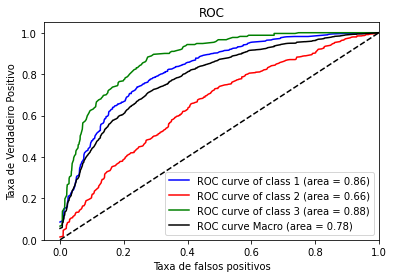

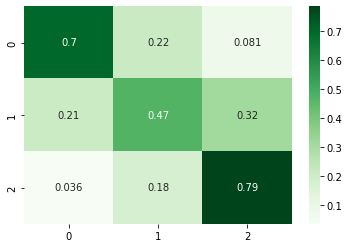

**********************0**********************
[84, 97, 30, 'adam', 0.0007721436454299951] -> accuracy:0.5 -> F1-Macro:0.46448527831506553recall score-macro:0.5788167560055589
**********************1**********************
[73, 92, 28, 'adam', 0.0008074079455701727] -> accuracy:0.5875 -> F1-Macro:0.5148987160160344recall score-macro:0.6155506730836298
**********************2**********************
[97, 91, 28, 'adam', 0.0009163837915597765] -> accuracy:0.575 -> F1-Macro:0.5020469169579976recall score-macro:0.576388888888889
**********************3**********************
[83, 94, 29, 'adam', 0.0008747640424571334] -> accuracy:0.5 -> F1-Macro:0.4650858113591032recall score-macro:0.5279596366552889
**********************4**********************
[70, 87, 27, 'adam', 0.0008578059916025983] -> accuracy:0.525 -> F1-Macro:0.4372447160682454recall score-macro:0.5847063706163104
**********************5**********************
[75, 67, 28, 'adam', 0.0009989685322943486] -> accuracy:0.48125 -> F1-Macro:0

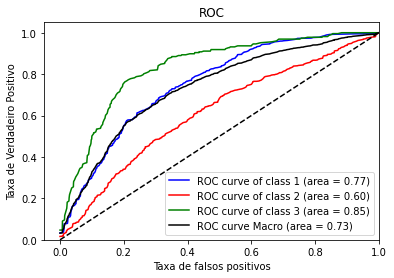

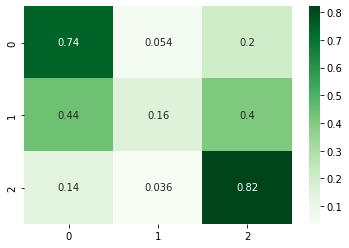

**********************0**********************
[91, 70, 26, 'adam', 0.0009431602452633242] -> accuracy:0.55 -> F1-Macro:0.5301099338609292recall score-macro:0.6171993911719938
**********************1**********************
[75, 86, 26, 'adam', 0.0009985910081504138] -> accuracy:0.59375 -> F1-Macro:0.5610452961672474recall score-macro:0.6209248796819419
**********************2**********************
[88, 87, 30, 'adam', 0.0008975512442247794] -> accuracy:0.6 -> F1-Macro:0.5701551247561731recall score-macro:0.6152777777777777
**********************3**********************
[92, 77, 29, 'adam', 0.0009386894929741166] -> accuracy:0.5125 -> F1-Macro:0.4836976745633194recall score-macro:0.536182144877797
**********************4**********************
[93, 69, 28, 'adam', 0.0009489057764093523] -> accuracy:0.6375 -> F1-Macro:0.59994227994228recall score-macro:0.6357681400013834
**********************5**********************
[95, 95, 29, 'adam', 0.0008945189914732225] -> accuracy:0.51875 -> F1-Macro:

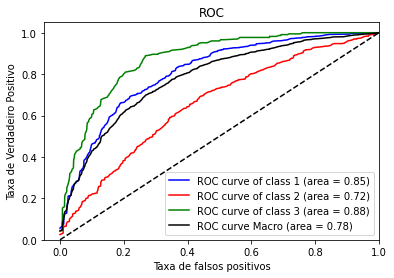

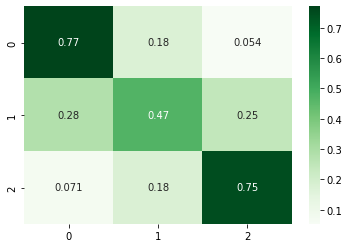

In [64]:
for Sampler in Sampler_list:
  #Definições de listas para gurdar os valores obtidos em cada iteração 
  #Lista para as pontuações atingidas para cada iteração
  Score_list = []
  #Lista para as pontuações f1-Maxro atingidas para cada iteração
  F1_macro   = []
  #Lista para as pontuações recall_score atingidas para cada iteração
  recall_score_macro = []
  #Lista para as matrizes de confusão atingidas em cada iteração
  cm_list    = []
  #FRP, TPR, ROC_AUC da classe 1
  FRP_0      = []
  TPR_0      = []
  ROC_auc_0  = []
  #FRP, TPR, ROC_AUC da classe 2
  FRP_1      = []
  TPR_1      = []
  ROC_auc_1  = []
  #FRP, TPR, ROC_AUC da classe 3
  FRP_2      = []
  TPR_2      = []
  ROC_auc_2  = []

  #Importancia dos hiperparametros
  h_0 = []
  h_1 = []
  h_2 = []
  h_3 = []
  h_4 = []

  #Iniciando iterações
  for i in range(10):
          #Chamada de cada fold 
          Train_test_Kfold(i)
          Best = 0.0
          reset_seeds()
          def objective(trial):         
            #Busca de hiperparametros utilizando o Optruna como otimizador
            neurons1    = trial.suggest_int("neurons1", 50, 100)
            neurons2    = trial.suggest_int("neurons2", 50, 100)
            max_iter    = trial.suggest_int("max_iter", 10, 30)
            solver      = trial.suggest_categorical("solver", ['adam', 'sgd'])
            learning_rate_init   = trial.suggest_float("learning_rate_init", 0.0001, 0.001)


            #Modelo Utilizado -> MLP
            model = MLPClassifier(hidden_layer_sizes=(neurons1,neurons2), max_iter=max_iter,solver=solver, verbose=False,  learning_rate_init=learning_rate_init)

            #Variaveis globais
            global Best
            global Model
            global Lista
            if Sampler == "SMOTE_Near":
              oversample = SMOTE(random_state = 9,sampling_strategy={2:480})
              X_res, y_res = oversample.fit_resample(Xtrain, ytrain)
              undersample=NearMiss(sampling_strategy={0:480, 1:480})
              X_res, y_res = undersample.fit_resample( X_res, y_res) 
            else:
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            #steps = [('over', SMOTE(random_state = 9)), ('model', model)]
            #pipeline = Pipeline(steps=steps)
            #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
            kfold = StratifiedKFold(n_splits=10)
            score = cross_val_score(model,X_res, y_res, scoring='accuracy', cv=kfold)
            #Pontuação media Obtida
            Score = score.mean()

            #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
            if Score > Best:
              Best = Score
              model.fit(X_res, y_res)
              Model = model
              Lista = [neurons1,neurons2,max_iter,solver,learning_rate_init]


            return Score

          #Chamada do Optuna 
          sampler = TPESampler(seed=42) 
          study = optuna.create_study(direction="maximize", sampler=sampler)
          #Definição do numero de iterações -> 100
          study.optimize(objective, n_trials=100)

          Importance = optuna.importance.get_param_importances(study)

          h_0.append(Importance["neurons1"])
          h_1.append(Importance["neurons2"])
          h_2.append(Importance["max_iter"])
          h_3.append(Importance["solver"])
          h_4.append(Importance["learning_rate_init"])
          

          #Ativação do modelo  para os dados de teste (1/10)
          ypred = Model.predict(Xtest)
          #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
          Acc = accuracy_score(ytest, ypred)
          F1 = f1_score(ytest, ypred, average='macro')
          rs = recall_score(ytest, ypred, average='macro')
          cm = confusion_matrix(ytest, ypred, normalize="true")
          #Append dos resultados obtidos na iteração
          Score_list.append(Acc)
          F1_macro.append(F1)
          recall_score_macro.append(rs)
          cm_list.append(cm)

          #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
          y_score = Model.predict_proba(Xtest)
          y_test = label_binarize(ytest, classes=[0,1,2])
          fpr = dict()
          tpr = dict()
          roc_auc = dict()
          for j in range(3):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
          FRP_0.append(fpr[0])
          TPR_0.append(tpr[0])
          ROC_auc_0.append(roc_auc[0])
          FRP_1.append(fpr[1])
          TPR_1.append(tpr[1])
          ROC_auc_1.append(roc_auc[1])
          FRP_2.append(fpr[2])
          TPR_2.append(tpr[2])
          ROC_auc_2.append(roc_auc[2])

          print("**********************"+str(i)+"**********************")
          print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

  #Criação da matriz de confusão media
  cm_sum = cm_list[0]
  for i in range(9):
    cm_sum = cm_list[i+1]+cm_sum
  cm_mean= cm_sum/10

  #Criação da curva ROC media
  all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

  mean_tpr_0 = np.zeros_like(all_fpr_0)
  for i in range(10):
      mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
  mean_tpr_0 /= 10

  all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

  mean_tpr_1 = np.zeros_like(all_fpr_1)
  for i in range(10):
      mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
  mean_tpr_1 /= 10


  all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

  mean_tpr_2 = np.zeros_like(all_fpr_2)
  for i in range(10):
      mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
  mean_tpr_2 /= 10

  FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
  TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

  all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
      mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
  mean_tpr /= 3
  #Pontuações e desvio padrão
  print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
  print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
  print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))
  print("neurons1: %.2f%%, neurons2: %.2f%%, max_iter: %.2f%%, solver: %.2f%%, learning_rate_init: %.2f%%" % (np.array(h_0).mean(), np.array(h_1).mean(), np.array(h_2).mean(),np.array(h_3).mean(),np.array(h_4).mean()))
  #Plots Finais
  roc_auc[3] = (auc(all_fpr, mean_tpr))
  colors = cycle(['blue', 'red', 'green'])
  a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
  b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
  for i, color in zip(range(3), colors):
      plt.plot(a[i], b[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i+1, roc_auc[i]))

  plt.plot(a[3], b[3], color="black",
              label='ROC curve Macro (area = {1:0.2f})'
              ''.format(1, roc_auc[3]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de falsos positivos')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()
  sns.heatmap(cm, annot=True, cmap="Greens")
  plt.show()

#***SVM (Support Vector Machines)***

**********************0**********************
[6, 'rbf', 7.55699924947228] -> accuracy:0.71875 -> F1-Macro:0.6965619501460126recall score-macro:0.7181413098625725
**********************1**********************
[7, 'rbf', 9.354899054769746] -> accuracy:0.69375 -> F1-Macro:0.6858233352094407recall score-macro:0.6908209527795215
**********************2**********************
[5, 'rbf', 9.933026307146742] -> accuracy:0.65 -> F1-Macro:0.6150701823955882recall score-macro:0.625
**********************3**********************
[10, 'rbf', 8.726761027986445] -> accuracy:0.58125 -> F1-Macro:0.5547385620915033recall score-macro:0.5633956938304764
**********************4**********************
[6, 'rbf', 9.084485357654312] -> accuracy:0.65625 -> F1-Macro:0.612351805900193recall score-macro:0.6123331258214014
**********************5**********************
[10, 'rbf', 9.289515769247503] -> accuracy:0.60625 -> F1-Macro:0.594320337311265recall score-macro:0.5890915791413304
**********************6**********

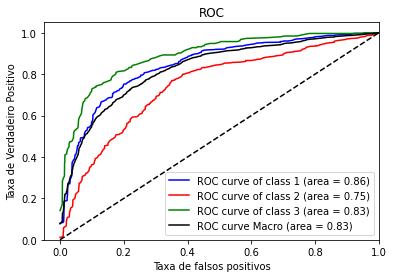

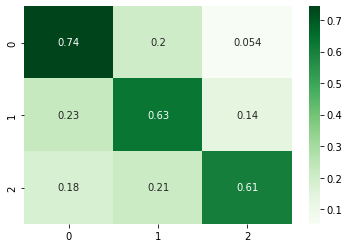

**********************0**********************
[4, 'rbf', 1.5402469796540308] -> accuracy:0.53125 -> F1-Macro:0.4889490718450757recall score-macro:0.6016478062338694
**********************1**********************
[1, 'rbf', 9.071128086747636] -> accuracy:0.55 -> F1-Macro:0.491337549990229recall score-macro:0.6049452465648323
**********************2**********************
[5, 'rbf', 5.469226508741166] -> accuracy:0.5 -> F1-Macro:0.44445474490899534recall score-macro:0.5027777777777778
**********************3**********************
[2, 'rbf', 3.5577493145073396] -> accuracy:0.51875 -> F1-Macro:0.48465739867609026recall score-macro:0.5414731501688023
**********************4**********************
[3, 'rbf', 3.677394600839777] -> accuracy:0.53125 -> F1-Macro:0.4842235744872662recall score-macro:0.5640347236632773
**********************5**********************
[1, 'rbf', 9.049893533208117] -> accuracy:0.425 -> F1-Macro:0.4086197434137295recall score-macro:0.46647235204449133
*********************

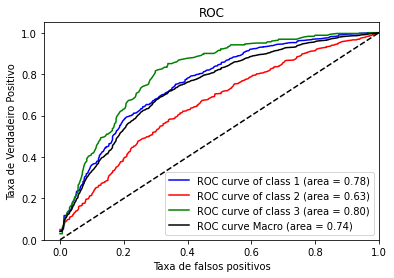

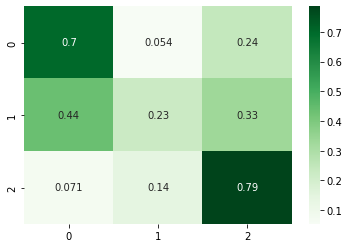

**********************0**********************
[6, 'rbf', 8.60975025101978] -> accuracy:0.70625 -> F1-Macro:0.6880783284442386recall score-macro:0.7079500584563122
**********************1**********************
[4, 'rbf', 8.308966338482637] -> accuracy:0.66875 -> F1-Macro:0.6484080752041916recall score-macro:0.6574806444862942
**********************2**********************
[6, 'rbf', 8.853357303019783] -> accuracy:0.65 -> F1-Macro:0.6126705653021443recall score-macro:0.6319444444444445
**********************3**********************
[5, 'rbf', 9.933026307146742] -> accuracy:0.53125 -> F1-Macro:0.5052669552669552recall score-macro:0.5165849078892557
**********************4**********************
[9, 'rbf', 8.901040975441683] -> accuracy:0.6625 -> F1-Macro:0.6376226520885898recall score-macro:0.6377118350971848
**********************5**********************
[10, 'rbf', 9.990275625867184] -> accuracy:0.6 -> F1-Macro:0.5957158310099486recall score-macro:0.5916377707422483


In [ ]:
for Sampler in Sampler_list:
  #Definições de listas para gurdar os valores obtidos em cada iteração 
  #Lista para as pontuações atingidas para cada iteração
  Score_list = []
  #Lista para as pontuações f1-Maxro atingidas para cada iteração
  F1_macro   = []
  #Lista para as pontuações recall_score atingidas para cada iteração
  recall_score_macro = []
  #Lista para as matrizes de confusão atingidas em cada iteração
  cm_list    = []
  #FRP, TPR, ROC_AUC da classe 1
  FRP_0      = []
  TPR_0      = []
  ROC_auc_0  = []
  #FRP, TPR, ROC_AUC da classe 2
  FRP_1      = []
  TPR_1      = []
  ROC_auc_1  = []
  #FRP, TPR, ROC_AUC da classe 3
  FRP_2      = []
  TPR_2      = []
  ROC_auc_2  = []

  #Importancia dos hiperparametros
  h_0 = []
  h_1 = []
  h_2 = []


  #Iniciando iterações
  for i in range(10):
          #Chamada de cada fold 
          Train_test_Kfold(i)
          Best = 0.0
          reset_seeds()
          def objective(trial):         
            #Busca de hiperparametros utilizando o Optruna como otimizador
            C = trial.suggest_int("C", 1, 10)
            kernel     = trial.suggest_categorical("kernel", ['linear','rbf', 'sigmoid'])
            gamma   = trial.suggest_float("gamma", 0.1, 10)

            #Modelo Utilizado -> SVN
            model = SVC(C=C, kernel=kernel, gamma=gamma,  random_state=0, probability=True)

            #Variaveis globais
            global Best
            global Model
            global Lista
            if Sampler == "SMOTE_Near":
              oversample = SMOTE(random_state = 9,sampling_strategy={2:480})
              X_res, y_res = oversample.fit_resample(Xtrain, ytrain)
              undersample=NearMiss(sampling_strategy={0:480, 1:480})
              X_res, y_res = undersample.fit_resample( X_res, y_res) 
            else:
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            #steps = [('over', SMOTE(random_state = 9)), ('model', model)]
            #pipeline = Pipeline(steps=steps)
            #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
            kfold = StratifiedKFold(n_splits=10)
            score = cross_val_score(model,X_res, y_res, scoring='accuracy', cv=kfold)
            #Pontuação media Obtida
            Score = score.mean()

            #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
            if Score > Best:
              Best = Score
              model.fit(X_res, y_res)
              Model = model
              Lista = [C, kernel, gamma]


            return Score

          #Chamada do Optuna 
          sampler = TPESampler(seed=42) 
          study = optuna.create_study(direction="maximize", sampler=sampler)
          #Definição do numero de iterações -> 100
          study.optimize(objective, n_trials=100)

          Importance = optuna.importance.get_param_importances(study)

          h_0.append(Importance["C"])
          h_1.append(Importance["kernel"])
          h_2.append(Importance["gamma"])

          

          #Ativação do modelo  para os dados de teste (1/10)
          ypred = Model.predict(Xtest)
          #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
          Acc = accuracy_score(ytest, ypred)
          F1 = f1_score(ytest, ypred, average='macro')
          rs = recall_score(ytest, ypred, average='macro')
          cm = confusion_matrix(ytest, ypred, normalize="true")
          #Append dos resultados obtidos na iteração
          Score_list.append(Acc)
          F1_macro.append(F1)
          recall_score_macro.append(rs)
          cm_list.append(cm)

          #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
          y_score = Model.predict_proba(Xtest)
          y_test = label_binarize(ytest, classes=[0,1,2])
          fpr = dict()
          tpr = dict()
          roc_auc = dict()
          for j in range(3):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
          FRP_0.append(fpr[0])
          TPR_0.append(tpr[0])
          ROC_auc_0.append(roc_auc[0])
          FRP_1.append(fpr[1])
          TPR_1.append(tpr[1])
          ROC_auc_1.append(roc_auc[1])
          FRP_2.append(fpr[2])
          TPR_2.append(tpr[2])
          ROC_auc_2.append(roc_auc[2])

          print("**********************"+str(i)+"**********************")
          print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

  #Criação da matriz de confusão media
  cm_sum = cm_list[0]
  for i in range(9):
    cm_sum = cm_list[i+1]+cm_sum
  cm_mean= cm_sum/10

  #Criação da curva ROC media
  all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

  mean_tpr_0 = np.zeros_like(all_fpr_0)
  for i in range(10):
      mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
  mean_tpr_0 /= 10

  all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

  mean_tpr_1 = np.zeros_like(all_fpr_1)
  for i in range(10):
      mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
  mean_tpr_1 /= 10


  all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

  mean_tpr_2 = np.zeros_like(all_fpr_2)
  for i in range(10):
      mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
  mean_tpr_2 /= 10

  FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
  TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

  all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
      mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
  mean_tpr /= 3

  #Pontuações e desvio padrão
  print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
  print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
  print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))
  print("C: %.2f%%, kernel: %.2f%%, gamma: %.2f%%" % (np.array(h_0).mean(), np.array(h_1).mean(), np.array(h_2).mean()))
  #Plots Finais
  roc_auc[3] = (auc(all_fpr, mean_tpr))
  colors = cycle(['blue', 'red', 'green'])
  a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
  b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
  for i, color in zip(range(3), colors):
      plt.plot(a[i], b[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i+1, roc_auc[i]))

  plt.plot(a[3], b[3], color="black",
              label='ROC curve Macro (area = {1:0.2f})'
              ''.format(1, roc_auc[3]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de falsos positivos')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()
  sns.heatmap(cm, annot=True, cmap="Greens")
  plt.show()